In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, to_timestamp, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import json

# 1. Start Spark session
spark = SparkSession.builder \
    .appName("BirdPresencePrediction") \
    .getOrCreate()

# 2. Load JSON data
df = spark.read.option("multiline", "true").json("birdsdetection11Tage.json")

# 3. Choose species of interest (e.g., European Greenfinch, id = 294)
TARGET_SPECIES_ID = 294

# 4. Extract relevant fields and create label column
data = df.select(
    col("timestamp"),
    col("species.id").alias("species_id")
).withColumn(
    "label", when(col("species_id") == TARGET_SPECIES_ID, 1).otherwise(0)
).withColumn(
    "hour_of_day", hour(to_timestamp("timestamp"))
).dropna(subset=["hour_of_day"])

# 5. Feature assembler
assembler = VectorAssembler(
    inputCols=["hour_of_day"],
    outputCol="features"
)
feature_data = assembler.transform(data)

# 6. Train/test split
train_data, test_data = feature_data.randomSplit([0.8, 0.2], seed=42)

train_data.groupBy("label").count().show()

# 7. Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)

# 8. Evaluate model
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)

print(f"Model AUC: {auc:.3f}")

# Optional: Show example predictions
predictions.select("hour_of_day", "label", "prediction", "probability").show(10)

# 9. Stop Spark session when done
spark.stop()

+-----+-----+
|label|count|
+-----+-----+
|    1|   10|
|    0|  159|
+-----+-----+

Model AUC: 0.929
+-----------+-----+----------+--------------------+
|hour_of_day|label|prediction|         probability|
+-----------+-----+----------+--------------------+
|         14|    1|       0.0|[0.58333333333368...|
|         14|    1|       0.0|[0.58333333333368...|
|         14|    1|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         14|    0|       0.0|[0.58333333333368...|
|         15|    0|       0.0|[0.99999979489710...|
|         15|    0|       0.0|[0.99999979489710...|
|         15|    0|       0.0|[0.99999979489710...|
+-----------+-----+----------+--------------------+
only showing top 10 rows



In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, to_timestamp, lit, explode, collect_set
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType, DoubleType
import json

# 1. Start Spark session
spark = SparkSession.builder.appName("BirdSpeciesPresenceByTime").getOrCreate()

# 2. Load the JSON data
df_raw = spark.read.option("multiline", "true").json("birdsdetection11Tage_backup.json")

# 3. Extract time-based features and species
df = df_raw.withColumn("timestamp", to_timestamp("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("speciesId", col("species.id")) \
    .withColumn("speciesName", col("species.commonName"))
    #.withColumn("day_of_week", dayofweek("timestamp")) \
    #.withColumn("speciesId", col("species.id")) \
    #.withColumn("speciesName", col("species.commonName"))

# 4. Get unique hours and days to create negative samples
#time_combinations = df.select("hour", "day_of_week").distinct()
time_combinations = df.select("hour").distinct()

# 5. Get all distinct species
species_list = df.select("speciesId", "speciesName").distinct().collect()

results = []

for row in species_list:
    species_id = row["speciesId"]
    species_name = row["speciesName"]
    
    # Positive samples for this species
    df_pos_raw = df.filter(col("speciesId") == species_id) \
                .select("hour") \
                .distinct()
               #.select("hour", "day_of_week") \
                #.select("hour") \
               #.distinct()
    
    # Negative samples = time slots where this species was NOT seen
    df_neg = time_combinations.subtract(df_pos_raw)

    # Now add labels
    df_pos = df_pos_raw.withColumn("label", lit(1))
    df_neg = df_neg.withColumn("label", lit(0))
    
    # Combine both
    df_model = df_pos.union(df_neg)
    
    # Assemble features
    #assembler = VectorAssembler(inputCols=["hour", "day_of_week"], outputCol="features")
    assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
    df_model = assembler.transform(df_model)
    
    # Train logistic regression
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    model = lr.fit(df_model)
    
    # Make predictions
    #predictions = model.transform(df_model).select("hour", "day_of_week", "label", "prediction", "probability")
    predictions = model.transform(df_model).select("hour", "label", "prediction", "probability")
    
    # Collect for inspection or saving
    results.append((species_name, predictions))

    print(f"✅ Trained model for {species_name}")

# Example: Show predictions for the first species
species_name, predictions_df = results[0]
print(f"\n🔍 Sample predictions for '{species_name}':")
#predictions_df.orderBy("hour", "day_of_week").show(10)
predictions_df.orderBy("hour").show(10)


🔍 Sample predictions for 'Crested Tit':
+----+-----+----------+--------------------+
|hour|label|prediction|         probability|
+----+-----+----------+--------------------+
|   0|    0|       0.0|[0.56241842097094...|
|   1|    0|       0.0|[0.59789104416322...|
|   2|    0|       0.0|[0.63236774346765...|
|   3|    0|       0.0|[0.66554200844927...|
|   4|    0|       0.0|[0.69715633858777...|
|   5|    1|       0.0|[0.72700810016342...|
|   6|    1|       0.0|[0.75495161990750...|
|   7|    1|       0.0|[0.78089686277394...|
|   8|    1|       0.0|[0.80480532614158...|
|   9|    0|       0.0|[0.82668393414550...|
+----+-----+----------+--------------------+
only showing top 10 rows



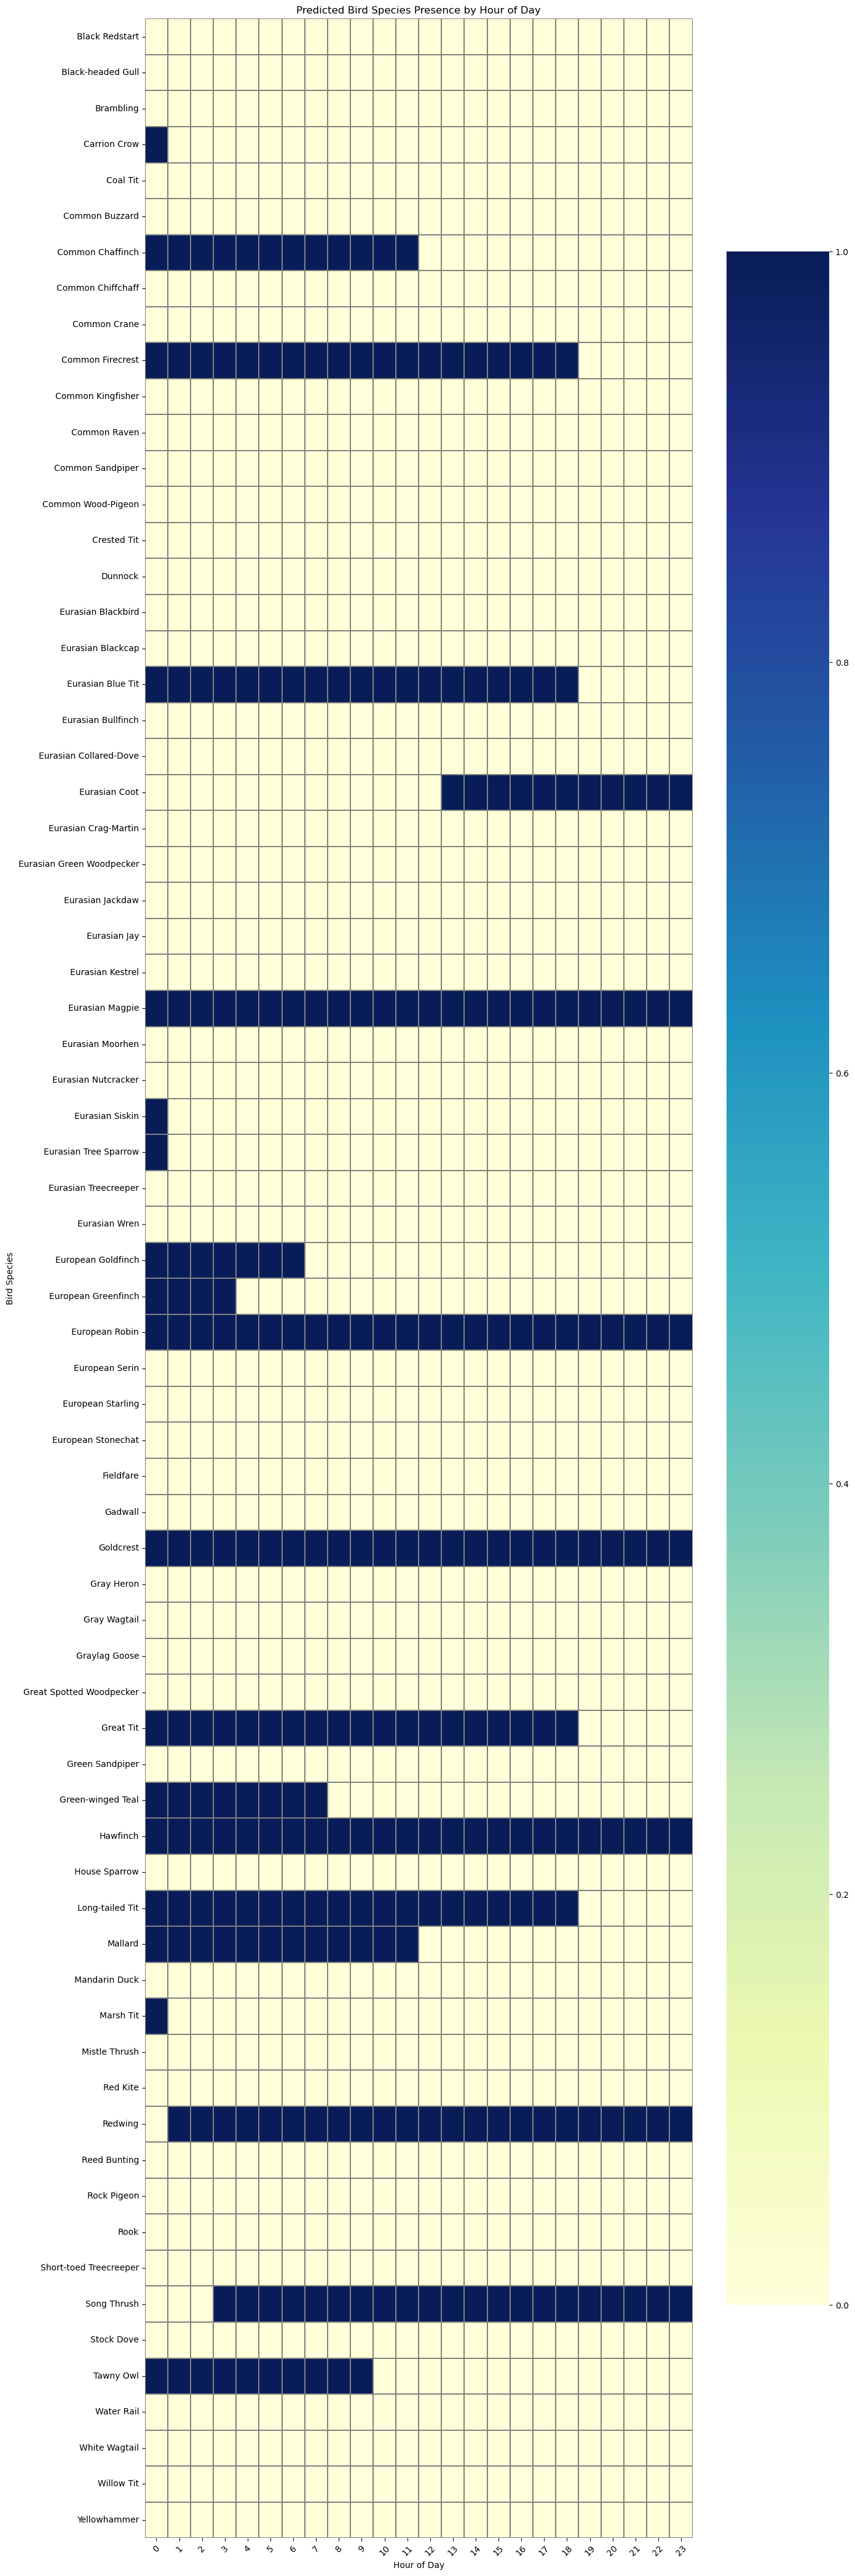

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions into a single Pandas DataFrame
all_preds = []

for species_name, predictions_df in results:
    # Get only hour and prediction columns
    pd_df = predictions_df.select("hour", "prediction").toPandas()
    pd_df["species"] = species_name
    all_preds.append(pd_df)

# Combine into one DataFrame
preds_df = pd.concat(all_preds)

# Pivot to make heatmap table: rows = species, columns = hours
heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="prediction", aggfunc="max").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, len(heatmap_data) * 0.6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')

plt.title("Predicted Bird Species Presence by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bird Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, hour, col, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC

# 1. Start Spark session
spark = SparkSession.builder.appName("BirdSpeciesPresenceByTime").getOrCreate()

# 2. Load the JSON data
df_raw = spark.read.option("multiline", "true").json("birdsdetection11Tage_backup.json")

# 3. Extract time-based features and species
df = df_raw.withColumn("timestamp", to_timestamp("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("speciesId", col("species.id")) \
    .withColumn("speciesName", col("species.commonName"))

# 4. Get unique hours to create negative samples
time_combinations = df.select("hour").distinct()

# 5. Get all distinct species
species_list = df.select("speciesId", "speciesName").distinct().collect()

results = []
rf_results = []

for row in species_list:
    species_id = row["speciesId"]
    species_name = row["speciesName"]
    
    # Positive samples for this species
    df_pos_raw = df.filter(col("speciesId") == species_id) \
                   .select("hour") \
                   .distinct()
    
    # Negative samples = time slots where this species was NOT seen
    df_neg = time_combinations.subtract(df_pos_raw)

    # Add labels: 1 for positive samples, 0 for negative samples
    df_pos = df_pos_raw.withColumn("label", lit(1))
    df_neg = df_neg.withColumn("label", lit(0))
    
    # Combine positive and negative samples
    df_model = df_pos.union(df_neg)
    
    # Assemble features
    assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
    df_model = assembler.transform(df_model)
    
    # --- Logistic Regression ---
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    lr_model = lr.fit(df_model)
    lr_predictions = lr_model.transform(df_model).select("hour", "label", "prediction", "probability")
    
    # --- Random Forest Classifier ---
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
    rf_model = rf.fit(df_model)
    rf_predictions = rf_model.transform(df_model).select("hour", "label", "prediction", "probability")
    
    # --- Support Vector Machine (LinearSVC) ---
    # Note: LinearSVC does not output a probability column
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)
    svm_model = svm.fit(df_model)
    svm_predictions = svm_model.transform(df_model).select("hour", "label", "prediction")
    
    # Collect results for comparison (each tuple contains species name and predictions for all three models)
    results.append((species_name, lr_predictions, rf_predictions, svm_predictions))
    
    print(f"✅ Trained models for {species_name}")

# 'results' now holds the prediction DataFrames for logistic regression, random forest, and SVM for each species.

✅ Trained models for Crested Tit
✅ Trained models for Rook
✅ Trained models for Reed Bunting
✅ Trained models for Stock Dove
✅ Trained models for Yellowhammer
✅ Trained models for Eurasian Siskin
✅ Trained models for Eurasian Moorhen
✅ Trained models for Common Sandpiper
✅ Trained models for Eurasian Magpie
✅ Trained models for Gray Heron
✅ Trained models for Common Wood-Pigeon
✅ Trained models for Common Buzzard
✅ Trained models for Eurasian Tree Sparrow
✅ Trained models for Eurasian Kestrel
✅ Trained models for Short-toed Treecreeper
✅ Trained models for Eurasian Jay
✅ Trained models for Hawfinch
✅ Trained models for Water Rail
✅ Trained models for Rock Pigeon
✅ Trained models for Mistle Thrush
✅ Trained models for Long-tailed Tit
✅ Trained models for European Greenfinch
✅ Trained models for Common Crane
✅ Trained models for Eurasian Treecreeper
✅ Trained models for Common Raven
✅ Trained models for Graylag Goose
✅ Trained models for European Goldfinch
✅ Trained models for Common Kin

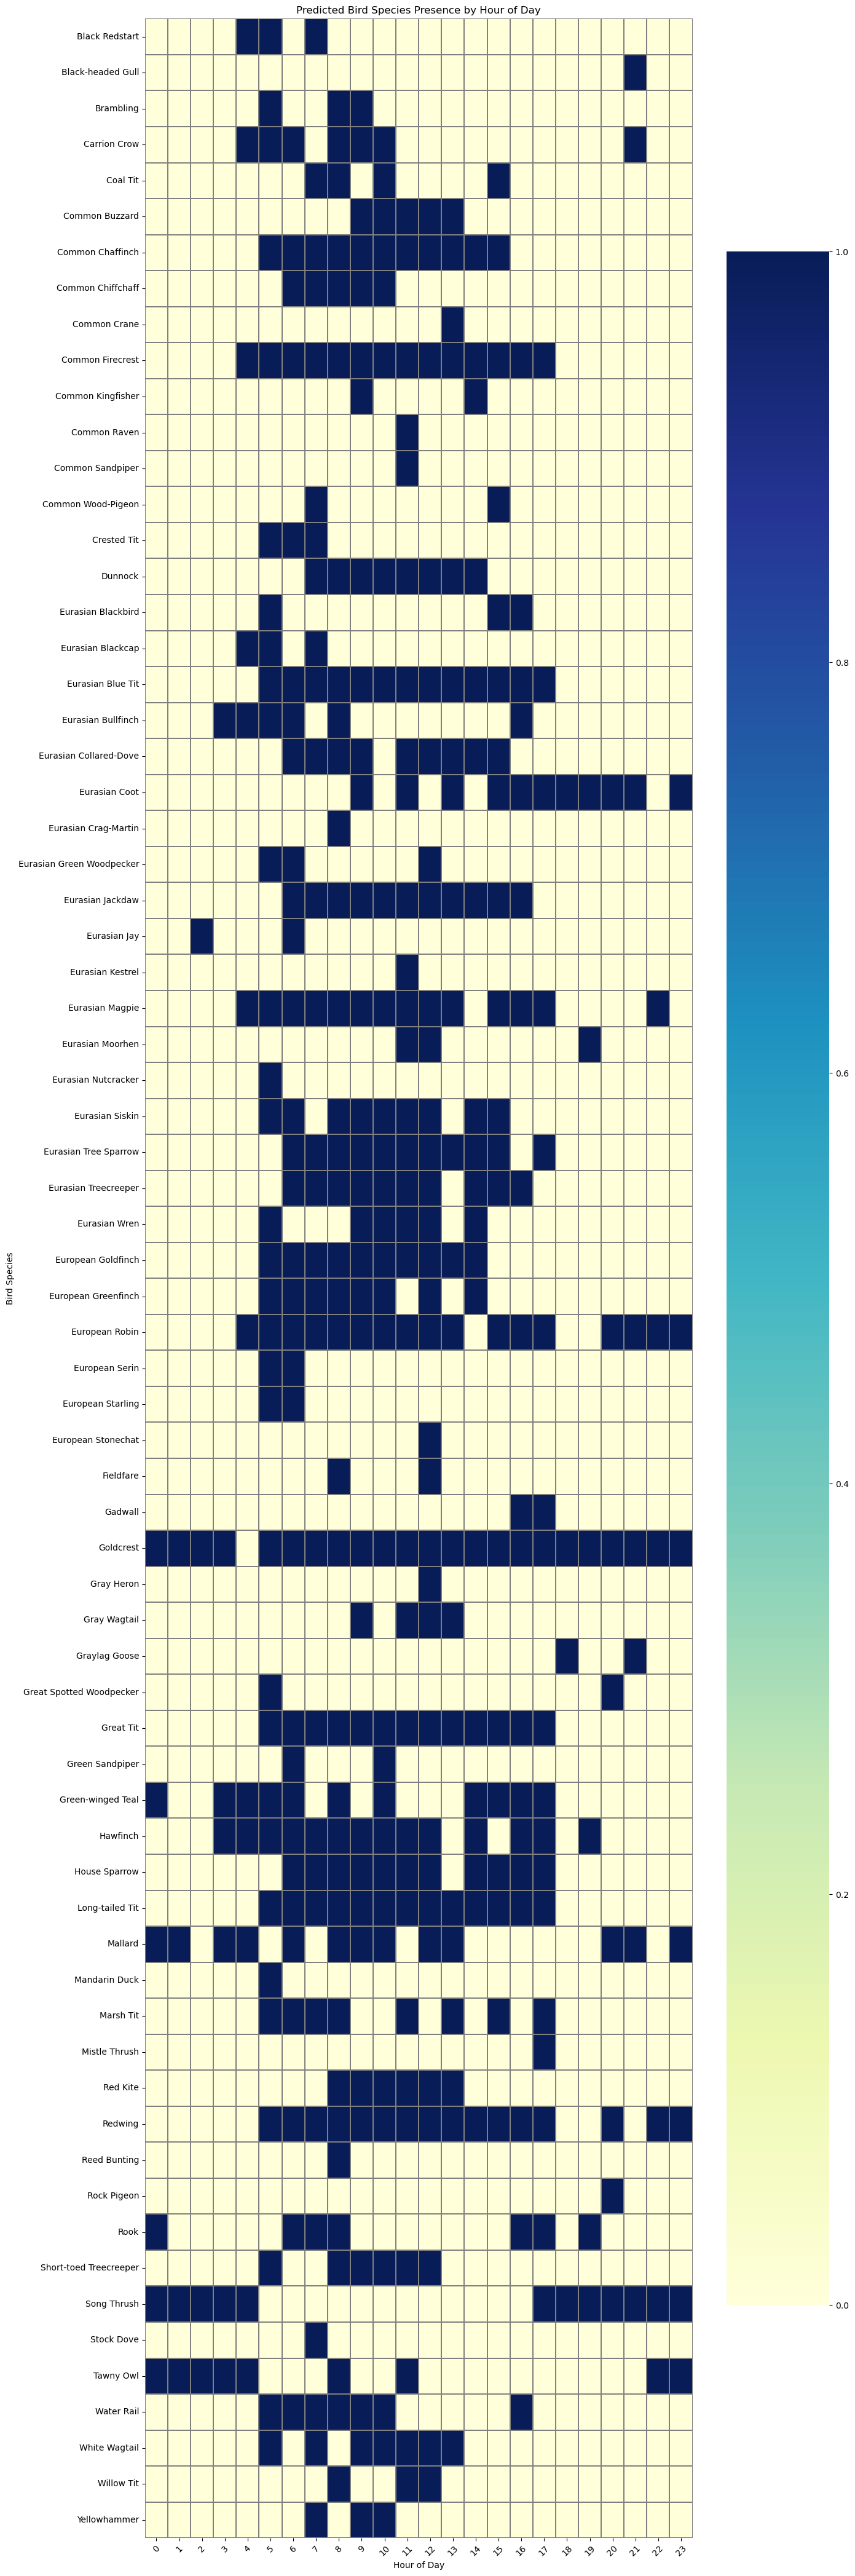

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions into a single Pandas DataFrame
all_preds = []

for species_name, lr_pred, rf_pred, svm_pred in results:
    # Get only hour and prediction columns
    pd_df = rf_pred.select("hour", "prediction").toPandas()
    pd_df["species"] = species_name
    all_preds.append(pd_df)

# Combine into one DataFrame
preds_df = pd.concat(all_preds)

# Pivot to make heatmap table: rows = species, columns = hours
heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="prediction", aggfunc="max").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, len(heatmap_data) * 0.6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')

plt.title("Predicted Bird Species Presence by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bird Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

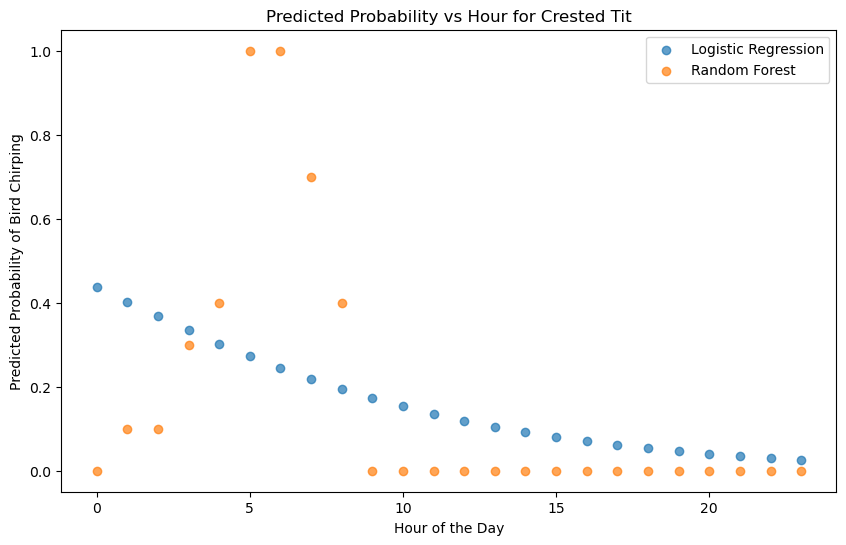

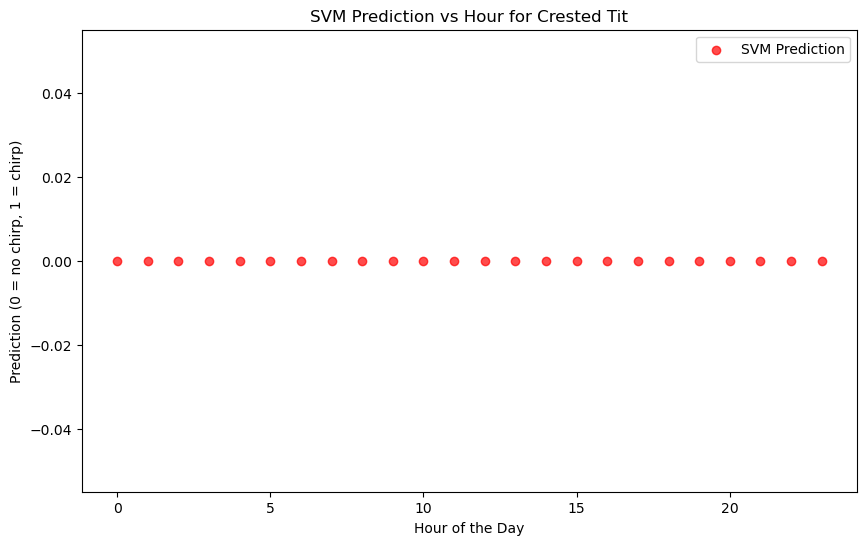

Accuracy for Crested Tit:
  Logistic Regression: 0.8333333333333334
  Random Forest: 0.9583333333333334
  SVM: 0.8333333333333334


IllegalArgumentException: rawPrediction does not exist. Available: hour, label, prediction, probability

In [5]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_timestamp, hour, col, lit
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# --- Visualization & Evaluation for the first species in our results ---
# (You can extend this loop to iterate over all species if needed.)
species_name, lr_pred, rf_pred, svm_pred = results[0]

# Convert Spark DataFrames to Pandas for plotting
lr_pd = lr_pred.toPandas()
rf_pd = rf_pred.toPandas()
svm_pd = svm_pred.toPandas()

# Plot predicted probabilities vs hour for Logistic Regression and Random Forest
plt.figure(figsize=(10,6))
# For each row, extract the probability for the positive class (index 1)
plt.scatter(lr_pd["hour"], lr_pd["probability"].apply(lambda x: x[1]), label="Logistic Regression", alpha=0.7)
plt.scatter(rf_pd["hour"], rf_pd["probability"].apply(lambda x: x[1]), label="Random Forest", alpha=0.7)
plt.xlabel("Hour of the Day")
plt.ylabel("Predicted Probability of Bird Chirping")
plt.title(f"Predicted Probability vs Hour for {species_name}")
plt.legend()
plt.show()

# For SVM, plot the predicted label vs hour
plt.figure(figsize=(10,6))
plt.scatter(svm_pd["hour"], svm_pd["prediction"], label="SVM Prediction", alpha=0.7, color="red")
plt.xlabel("Hour of the Day")
plt.ylabel("Prediction (0 = no chirp, 1 = chirp)")
plt.title(f"SVM Prediction vs Hour for {species_name}")
plt.legend()
plt.show()

# --- Model Evaluation ---
# Using MulticlassClassificationEvaluator to compute accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_pred)
rf_accuracy = evaluator.evaluate(rf_pred)
svm_accuracy = evaluator.evaluate(svm_pred)

print(f"Accuracy for {species_name}:")
print(f"  Logistic Regression: {lr_accuracy}")
print(f"  Random Forest: {rf_accuracy}")
print(f"  SVM: {svm_accuracy}")

# Using BinaryClassificationEvaluator to compute AUC (Area Under ROC)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = binary_evaluator.evaluate(lr_pred)
rf_auc = binary_evaluator.evaluate(rf_pred)
svm_auc = binary_evaluator.evaluate(svm_pred)

print(f"AUC for {species_name}:")
print(f"  Logistic Regression: {lr_auc}")
print(f"  Random Forest: {rf_auc}")
print(f"  SVM: {svm_auc}")

# Bar chart comparing evaluation metrics
metrics = {
    "Logistic Regression Accuracy": lr_accuracy,
    "Random Forest Accuracy": rf_accuracy,
    "SVM Accuracy": svm_accuracy,
    "Logistic Regression AUC": lr_auc,
    "Random Forest AUC": rf_auc,
    "SVM AUC": svm_auc
}

plt.figure(figsize=(12, 6))
names = list(metrics.keys())
values = list(metrics.values())
plt.bar(names, values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Metric Value")
plt.title(f"Model Evaluation Metrics for {species_name}")
plt.show()

Accuracy:
  Logistic Regression: 0.0
  Random Forest: 0.6666666666666666
  SVM: 0.5833333333333334
AUC:
  Logistic Regression: 0.6
  Random Forest: 1.0
  SVM: 0.5


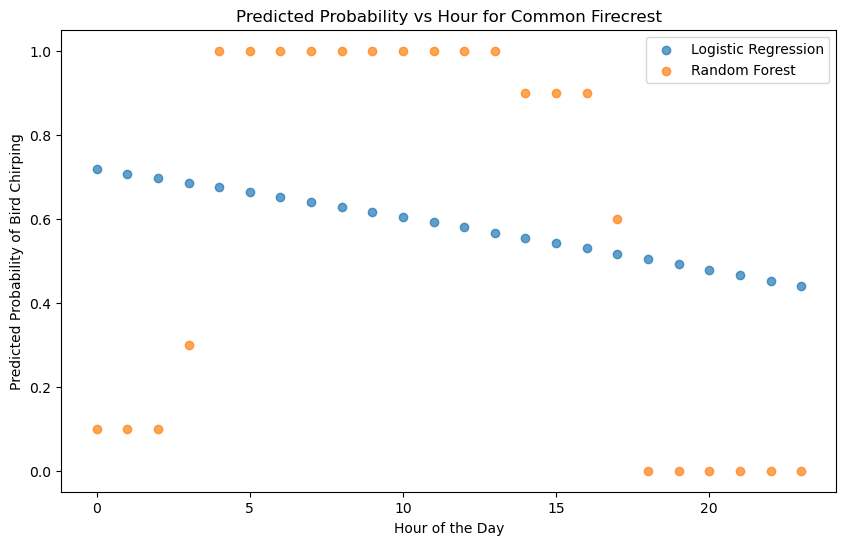

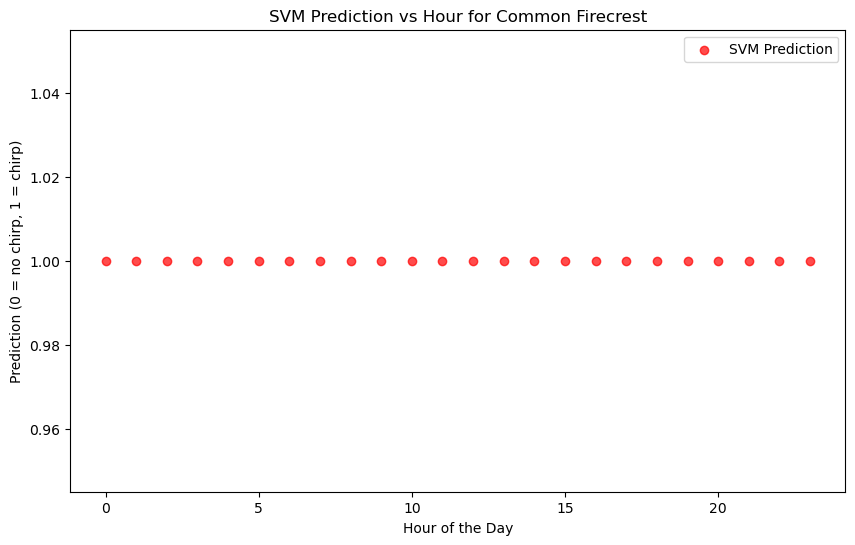

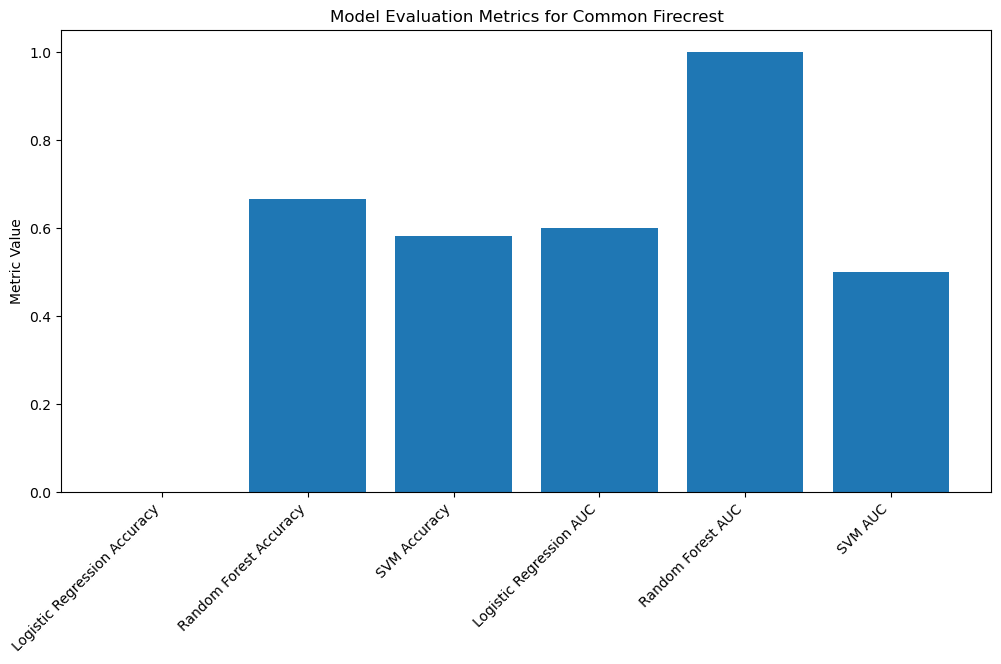

In [10]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

species_name, lr_pred, rf_pred, svm_pred = results[57]

# Define a UDF to extract the positive class probability (index 1)
def extract_positive_prob(prob):
    return float(prob[1])
extract_positive_prob_udf = udf(extract_positive_prob, DoubleType())

# For logistic regression and random forest predictions, create a "score" column from the "probability" vector
lr_pred = lr_pred.withColumn("prediction", extract_positive_prob_udf(col("probability")))
rf_pred = rf_pred.withColumn("prediction", extract_positive_prob_udf(col("probability")))
# For SVM, if rawPrediction is already a double, you can use it directly;
# if not, you may need a similar extraction depending on your Spark version.

# --- Model Evaluation ---
# Evaluate using MulticlassClassificationEvaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_pred)
rf_accuracy = evaluator.evaluate(rf_pred)
svm_accuracy = evaluator.evaluate(svm_pred)

print("Accuracy:")
print(f"  Logistic Regression: {lr_accuracy}")
print(f"  Random Forest: {rf_accuracy}")
print(f"  SVM: {svm_accuracy}")

# Evaluate using BinaryClassificationEvaluator for AUC (Area Under ROC)
# Set rawPredictionCol to the new "score" column for LR and RF.
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
lr_auc = binary_evaluator.evaluate(lr_pred)
rf_auc = binary_evaluator.evaluate(rf_pred)
# For SVM, assuming rawPrediction is appropriate, we can evaluate it directly.
svm_auc = binary_evaluator.evaluate(svm_pred)

print("AUC:")
print(f"  Logistic Regression: {lr_auc}")
print(f"  Random Forest: {rf_auc}")
print(f"  SVM: {svm_auc}")

# --- Visualization ---
# Convert Spark DataFrames to Pandas for plotting (for one species, as an example)
lr_pd = lr_pred.toPandas()
rf_pd = rf_pred.toPandas()
svm_pd = svm_pred.toPandas()

# Plot predicted probabilities vs. hour for Logistic Regression and Random Forest
plt.figure(figsize=(10,6))
plt.scatter(lr_pd["hour"], lr_pd["probability"].apply(lambda x: x[1]), label="Logistic Regression", alpha=0.7)
plt.scatter(rf_pd["hour"], rf_pd["probability"].apply(lambda x: x[1]), label="Random Forest", alpha=0.7)
plt.xlabel("Hour of the Day")
plt.ylabel("Predicted Probability of Bird Chirping")
plt.title(f"Predicted Probability vs Hour for {species_name}")
plt.legend()
plt.show()

# For SVM, plot predicted labels vs. hour (as it does not output probabilities)
plt.figure(figsize=(10,6))
plt.scatter(svm_pd["hour"], svm_pd["prediction"], label="SVM Prediction", alpha=0.7, color="red")
plt.xlabel("Hour of the Day")
plt.ylabel("Prediction (0 = no chirp, 1 = chirp)")
plt.title(f"SVM Prediction vs Hour for {species_name}")
plt.legend()
plt.show()

# Bar chart comparing evaluation metrics
import numpy as np

metrics = {
    "Logistic Regression Accuracy": lr_accuracy,
    "Random Forest Accuracy": rf_accuracy,
    "SVM Accuracy": svm_accuracy,
    "Logistic Regression AUC": lr_auc,
    "Random Forest AUC": rf_auc,
    "SVM AUC": svm_auc
}

plt.figure(figsize=(12, 6))
names = list(metrics.keys())
values = list(metrics.values())
plt.bar(names, values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Metric Value")
plt.title(f"Model Evaluation Metrics for {species_name}")
plt.show()

In [9]:
target_species = "Common Firecrest"
index = next((i for i, (species, _, _, _) in enumerate(results) if species == target_species), -1)

print("Index:", index)

Index: 57
